In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [42]:
#Reading the file and splitting our target column
df = pd.read_csv (r'bank-additional-full.csv', sep = ';', engine= 'python')   

#categories_filter = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

#for x in categories_filter:
#    df.drop(df.index[df[x] == 'unknown'], inplace=True)

tussen = df[["y"]]
target = tussen.copy()
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

#Encoding all the catergorical variables and deleting them from the old dataframe
categories = ['marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
df_encoded = pd.get_dummies(df['job'], prefix='job', drop_first=True)
df_encoded.insert(0, 'ID', range(0, len(df_encoded)))
del df['job']

for x in categories:
    df_encoded_tussen = pd.get_dummies(df[x], prefix=x, drop_first=True)
    df_encoded_tussen.insert(0, 'ID', range(0, len(df_encoded_tussen)))
    df_encoded = pd.merge(df_encoded, df_encoded_tussen, on = 'ID', how = 'outer')
    del df[x]

df.insert(0, 'ID', range(0, len(df)))
features = pd.merge(df_encoded, df, on = 'ID', how = 'outer')
y = pd.get_dummies(target, drop_first=True)
del features['ID']

In [43]:
undersample = NearMiss(version=1, n_neighbors_ver3=3)
features, y = undersample.fit_resample(features, y)

In [55]:
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)
#Logistics Regression
logisticRegr = LogisticRegression(solver='lbfgs', max_iter = 20000)

# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(logisticRegr, train_features, train_targets,scoring='roc_auc', cv=cv, n_jobs=-1)
print("AUC Cross Validation Training Set: {}".format(np.round(np.mean(scores) , 3)))

logisticRegr.fit(train_features, train_targets)

predictions = logisticRegr.predict(test_features)

# Use score method to get accuracy of model
score = logisticRegr.score(test_features, test_targets)
print(np.round(score , 3))

AUC Cross Validation Training Set: 0.909
0.83


Confusion Matrix:
[[799 136]
 [180 741]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       935
           1       0.84      0.80      0.82       921

    accuracy                           0.83      1856
   macro avg       0.83      0.83      0.83      1856
weighted avg       0.83      0.83      0.83      1856



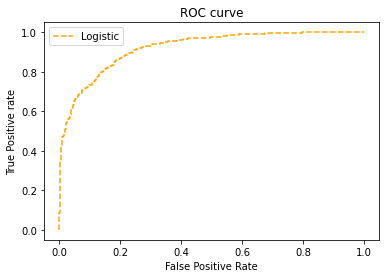

AUC Score Test Set: 0.921
Log-Loss: 5.881


In [56]:
print("Confusion Matrix:")
print(confusion_matrix(test_targets, predictions))

print("Classification Report")
print(classification_report(test_targets, predictions))

#Beginning the plotting of ROC-curve
pred_prob = logisticRegr.predict_proba(test_features)
fpr, tpr, thresh = roc_curve(test_targets, pred_prob[:,1], pos_label=1)
    
#Plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();
    
#AUC Score
auc_score = roc_auc_score(test_targets, pred_prob[:,1])
print("AUC Score Test Set: " + str(np.round(auc_score,3)))

#Log-loss function
print("Log-Loss: " + str(np.round(log_loss(test_targets, predictions),3)))

In [57]:
param_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty': ['none', 'l1', 'l2', 'elasticnet'], 'C': [0.01,0.1,1,10,100]
              }
grid = GridSearchCV(logisticRegr,param_grid,refit=True,verbose=2)
grid.fit(train_features,train_targets)
print(grid.best_estimator_)

grid_predictions = grid.predict(test_features)
print(confusion_matrix(test_targets,grid_predictions))
print(classification_report(test_targets,grid_predictions))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END .............C=0.01, penalty=none, solver=newton-cg; total time=   4.9s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not

[CV] END .............C=0.01, penalty=none, solver=newton-cg; total time=   3.4s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END .............C=0.01, penalty=none, solver=newton-cg; total time=   3.8s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END .............C=0.01, penalty=none, solver=newton-cg; total time=   5.2s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .............C=0.01, penalty=none, solver=newton-cg; total time=   4.0s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   0.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   2.1s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   0.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   0.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   1.6s
[CV] END .............C=0.01, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, penalty=none, solver=liblinear; total time=   0.0s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.01, penalty=none, solver=sag; total time=  21.2s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.01, penalty=none, solver=sag; total time=  23.3s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.01, penalty=none, solver=sag; total time=  22.4s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.01, penalty=none, solver=sag; total time=  22.7s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.01, penalty=none, solver=sag; total time=  22.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=none, solver=saga; total time=  29.4s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=none, solver=saga; total time=  29.2s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=none, solver=saga; total time=  28.8s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=none, solver=saga; total time=  28.3s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=none, solver=saga; total time=  28.7s
[CV] END ...............C=0.01, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=  14.0s
[CV] END ...............C=0.

/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   1.2s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   1.0s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   1.1s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   1.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=  20.6s
[CV] END ...................

/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END ..............C=0.1, penalty=none, solver=newton-cg; total time=   6.8s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not

[CV] END ..............C=0.1, penalty=none, solver=newton-cg; total time=   4.7s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ..............C=0.1, penalty=none, solver=newton-cg; total time=   4.2s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ..............C=0.1, penalty=none, solver=newton-cg; total time=   6.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=0.1, penalty=none, solver=newton-cg; total time=   4.7s
[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.7s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   2.9s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.7s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   1.9s
[CV] END ..............C=0.1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, penalty=none, solver=liblinear; total time=   0.0s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=0.1, penalty=none, solver=sag; total time=  21.9s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=0.1, penalty=none, solver=sag; total time=  24.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=0.1, penalty=none, solver=sag; total time=  23.2s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=0.1, penalty=none, solver=sag; total time=  22.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=0.1, penalty=none, solver=sag; total time=  23.7s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=none, solver=saga; total time=  28.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=none, solver=saga; total time=  28.0s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=none, solver=saga; total time=  27.4s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=none, solver=saga; total time=  27.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=none, solver=saga; total time=  27.3s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time= 1.2min
[CV] END ................C=0

/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.4s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.7s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.8s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   1.4s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......................C=0.1, penalty=l2, solver=sag; total time=  21.5s
[CV] END ...................

/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END ................C=1, penalty=none, solver=newton-cg; total time=   4.8s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ................C=1, penalty=none, solver=newton-cg; total time=   3.3s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ................C=1, penalty=none, solver=newton-cg; total time=   3.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ................C=1, penalty=none, solver=newton-cg; total time=   5.2s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=1, penalty=none, solver=newton-cg; total time=   3.7s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.6s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   2.2s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.5s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.6s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   1.7s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ......................C=1, penalty=none, solver=sag; total time=  21.3s
[CV] END ...................

/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   2.7s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: 

[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   1.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   2.3s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   1.7s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   1.8s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   1.8s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=  24.7s
[CV] END ...................

/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END ...............C=10, penalty=none, solver=newton-cg; total time=   3.7s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not

[CV] END ...............C=10, penalty=none, solver=newton-cg; total time=   3.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ...............C=10, penalty=none, solver=newton-cg; total time=   3.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ...............C=10, penalty=none, solver=newton-cg; total time=   5.2s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...............C=10, penalty=none, solver=newton-cg; total time=   3.6s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.7s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   2.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   1.7s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .....................C=10, penalty=none, solver=sag; total time=  21.7s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .....................C=10, penalty=none, solver=sag; total time=  21.3s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .....................C=10, penalty=none, solver=sag; total time=  21.3s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .....................C=10, penalty=none, solver=sag; total time=  20.7s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .....................C=10, penalty=none, solver=sag; total time=  21.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=none, solver=saga; total time=  27.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=none, solver=saga; total time=  27.3s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=none, solver=saga; total time=  27.4s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=none, solver=saga; total time=  26.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=none, solver=saga; total time=  27.4s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time= 2.4min
[CV] END .................C=

/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   7.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   4.4s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   6.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=  13.5s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.2s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   1.9s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   0.6s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   1.7s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=  23.1s
[CV] END ...................

/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END ..............C=100, penalty=none, solver=newton-cg; total time=   5.2s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not

[CV] END ..............C=100, penalty=none, solver=newton-cg; total time=   4.1s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ..............C=100, penalty=none, solver=newton-cg; total time=   4.2s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ..............C=100, penalty=none, solver=newton-cg; total time=   6.4s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=100, penalty=none, solver=newton-cg; total time=   5.0s
[CV] END ..................C=100, penalty=none, solver=lbfgs; total time=   0.7s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=100, penalty=none, solver=lbfgs; total time=   2.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=100, penalty=none, solver=lbfgs; total time=   0.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=100, penalty=none, solver=lbfgs; total time=   1.0s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=100, penalty=none, solver=lbfgs; total time=   2.0s
[CV] END ..............C=100, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, penalty=none, solver=liblinear; total time=   0.0s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=100, penalty=none, solver=sag; total time=  23.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=100, penalty=none, solver=sag; total time=  23.3s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=100, penalty=none, solver=sag; total time=  23.2s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=100, penalty=none, solver=sag; total time=  22.3s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=100, penalty=none, solver=sag; total time=  23.3s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=none, solver=saga; total time=  30.7s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=none, solver=saga; total time=  30.9s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=none, solver=saga; total time=  29.7s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=none, solver=saga; total time=  29.4s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=none, solver=saga; total time=  30.1s
[CV] END ................C=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time= 2.2min
[CV] END ................C=1

/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   5.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=  12.9s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=  14.0s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=  13.6s


/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=  11.7s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   2.4s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.8s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   1.1s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ......................C=100, penalty=l2, solver=sag; total time=  24.4s
[CV] END ...................

/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", lin

/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

LogisticRegression(C=10, max_iter=20000, solver='newton-cg')
[[798 137]
 [167 754]]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       935
           1       0.85      0.82      0.83       921

    accuracy                           0.84      1856
   macro avg       0.84      0.84      0.84      1856
weighted avg       0.84      0.84      0.84      1856



/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ziadm/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
